<a href="https://colab.research.google.com/github/clifford-cheng/AmazonReviewNLP/blob/master/AmazonReviewNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install spacy
# !pip install spacy-transformers
#!python -m spacy download en_trf_bertbaseuncased_lg
#nltk.download('wordnet')

In [4]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

from yellowbrick.text import TSNEVisualizer
from sklearn.cluster import KMeans


from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text
from sklearn.metrics import classification_report as report
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.decomposition import NMF
import gzip

import json
import matplotlib.pyplot as plt
import re

#nlp = spacy.load('en_trf_bertbaseuncased_lg')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import IPython.display
IPython.display.set_matplotlib_formats('svg')
import string
nltk.download('stopwords')
nltk.download('punkt')
stopwords_ = set(stopwords.words('english'))
punctuation_ = set(string.punctuation)

from nltk.stem.snowball import SnowballStemmer
stemmer_snowball = SnowballStemmer('english')

from nltk.stem.porter import PorterStemmer
stemmer_porter = PorterStemmer()

from nltk import pos_tag

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Cleaning, plotting, and tokenizing scripts

In [5]:
def filter_tokens(sent):
    return([w for w in sent if not w in stopwords_ and not w in punctuation_])

def combine_list(lists):
    flat_list = []
    for sublist in lists:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def stemming(clean_data):
    _list = []
    ps = nltk.stem.SnowballStemmer('english')
    for i in clean_data:
        _list.append(ps.stem(i))
    return _list

def clean_data(string):
    alphabets = list(map(chr, range(97, 97+26))) + ["."]
    input_string = [c if c in alphabets else ' ' for c in string.lower()] 
    input_string = "".join(input_string)
    input_string = input_string.replace(' . ', '')
    input_string = re.sub(' +', ' ', input_string)
    
    sent_tokens = sent_tokenize(input_string)
    tokens = [sent for sent in map(word_tokenize, sent_tokens)]
    tokens_filtered = list(map(filter_tokens, tokens))

    tokens_combine = combine_list(tokens_filtered)
    
    stem = stemming(tokens_combine)

    return stem

def get_word_matrix(df_one):
    final_list = []
    for i in tqdm(range(len(df_one['reviewText']))):
        temp = df_one['reviewText'][i]
        final_list.append(clean_data(temp))
    return final_list

def get_dictionary(corpus):
  corpus_dict = {}
  for i in corpus:
      for j in i:
          if j in corpus_dict:
              corpus_dict[j] +=1
          else:
              corpus_dict[j] = 1
  sort_dict = {k: v for k, v in sorted(corpus_dict.items(), key=lambda item: item[1], reverse=True)}
  return sort_dict

def categorize_overall(df):
    if df['overall'] <=3:
        return 'Low Rating'
    elif df['overall'] >=4:
        return 'High Rating'

def product_rating(table):
    below_three = table[table['overall']<=3.0].reset_index(inplace=False, drop=True)
    above_four = table[table['overall']>=4.0].reset_index(inplace=False, drop=True)
    
    total = len(table)
    below_three_per = round((len(below_three)/total),2)
    above_four_per = round((len(above_four)/total),2)
    
    
    labels = ['1-3 Stars', '4+ Stars']
    rating_count = [len(below_three), len(above_four)]
    x = np.arange(len(labels)) 
    
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, rating_count, width, label='Stars')

    ax.set_ylabel('Count')
    ax.set_title('Ratings Percentage')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            percent = round(100*(height/len(table)),1)
            ax.annotate('{}'.format(str(percent)+'%'),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 0 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    fig.tight_layout()
    plt.show()
    return below_three, above_four


# 1. Data Cleaning: Data Import and Cleaning

1.   Import gzip json file
2.   Remove unwanted columns and nulls (not many nulls)
3.   Convert strings to different column data types
4.   Remove duplicates
5.   Add column ['overall_category'] based on overall score. 1-3: Low | 4+: High



In [6]:
table=[]
with gzip.GzipFile("/content/drive/My Drive/Galvanize/Capstones/capstone_2/data/Luxury_Beauty.json.gz", 'r') as f:   
    for line in f:
        table.append(json.loads(line))
df = pd.DataFrame(table)
df = df.drop(columns = ['reviewTime','reviewerID', 'reviewerName', 'unixReviewTime', 'image', 'style'], axis=0)
df = df[df['reviewText'].notnull()]

df = df.fillna(0)

df['overall'] = df['overall'].astype(int)
df.replace(',','', regex=True, inplace=True)
df['vote'] = df['vote'].astype(int)

df = df.drop_duplicates(subset=['reviewText'], keep=False)
df = df.reset_index(drop=True)
df['overall_category'] = df.apply(categorize_overall, axis=1)

#Remove 3s
#df = df[df['overall']!=3].reset_index(drop=True)

asin_list = df['asin'].unique()

In [7]:
df

,overall,vote,verified,asin,reviewText,summary,overall_category
0,2,3,True,B00004U9V2,I bought two of these 8.5 fl oz hand cream and...,dispensers don't work,Low Rating
1,5,14,True,B00004U9V2,Believe me over the years I have tried many ma...,Best hand cream ever.,High Rating
2,5,0,True,B00004U9V2,Ive used this lotion for many years. I try oth...,Ive used this lotion for many years. I try ...,High Rating
3,5,0,True,B00004U9V2,Works great for dry hands.,Five Stars,High Rating
4,5,0,True,B00004U9V2,I am a healthcare care professional that suffe...,Best hand therapy on the market!!,High Rating
...,...,...,...,...,...,...,...
425414,5,0,True,B01HIQEOLO,Love CND shellac. Nice color,Great product,High Rating
425415,5,0,True,B01HIQEOLO,Great color and I prefer shellac over gel,Five Stars,High Rating
425416,5,0,True,B01HIQEOLO,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,High Rating
425417,5,0,True,B01HIQEOLO,Great polish and beautiful color!!,Great polish!,High Rating


## 1. Data Cleaning: Further data cleaning...

1.   Script to re-weight upvotes by the sqrt of the upvotes. Log was too harsh.
2.   Get top products by reviews to be used later for specific product analysis.
3.   Split data by Low Rating and High Rating into different dataframes to be used later.






In [8]:
# df_new = df.loc[df.index.repeat(round(np.log(df.vote+2)))].reset_index(drop=True)
# df_new

df_new = df.loc[df.index.repeat(round(np.sqrt(df.vote+1)))].reset_index(drop=True)
df_new

,overall,vote,verified,asin,reviewText,summary,overall_category
0,2,3,True,B00004U9V2,I bought two of these 8.5 fl oz hand cream and...,dispensers don't work,Low Rating
1,2,3,True,B00004U9V2,I bought two of these 8.5 fl oz hand cream and...,dispensers don't work,Low Rating
2,5,14,True,B00004U9V2,Believe me over the years I have tried many ma...,Best hand cream ever.,High Rating
3,5,14,True,B00004U9V2,Believe me over the years I have tried many ma...,Best hand cream ever.,High Rating
4,5,14,True,B00004U9V2,Believe me over the years I have tried many ma...,Best hand cream ever.,High Rating
...,...,...,...,...,...,...,...
558920,5,0,True,B01HIQEOLO,Great color and I prefer shellac over gel,Five Stars,High Rating
558921,5,0,True,B01HIQEOLO,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,High Rating
558922,5,0,True,B01HIQEOLO,Great polish and beautiful color!!,Great polish!,High Rating
558923,1,2,True,B01HJ2UY0W,The perfume is good but the spray head broke off.,Spray head broke off within a month,Low Rating


In [9]:
top_products = df_new.groupby(df_new.asin).count().sort_values(by='reviewText', ascending=False)
top_products[0:15]

,overall,vote,verified,reviewText,summary,overall_category
asin,,,,,,
B000PZA2KS,3283,3283,3283,3283,3283,3283
B000ASDGK8,3056,3056,3056,3056,3056,3056
B00EXW53GC,3040,3040,3040,3040,3040,3040
B002K6AHQY,2836,2836,2836,2836,2836,2836
B001T0HHDS,2640,2640,2640,2640,2640,2640
B0031NNE56,2606,2606,2606,2606,2606,2606
B00837YY18,2564,2564,2564,2564,2564,2564
B00HX27AM4,2533,2533,2533,2533,2533,2533
B000NL0T1G,2222,2222,2222,2222,2222,2222


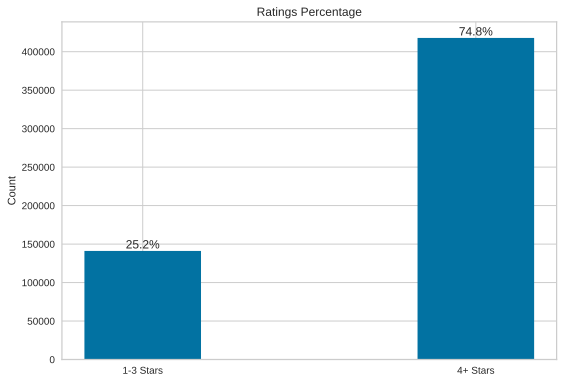

In [10]:
df_below_three, df_above_four = product_rating(df_new)

# 2. Data Exploration: Plot TSNE for High and Low rating. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


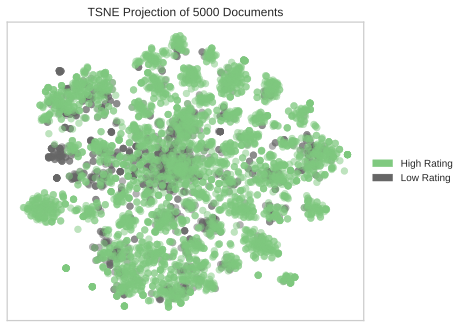

In [11]:

my_stop_words = text.ENGLISH_STOP_WORDS.union(["really", "just", "don", "like", "total", "does", "did", "months", "amazon", "left", "ve",
                                                "hair", "nails", "flat iron", "flat", "curling iron", "curling", "iron", "half", "curl",
                                                "rollers", "products", "spray", "rollers", "lotion", "love", "dry shampoo", "conditioner",
                                                "pump", "shampoos", "shampoo", "dry shampoo", "bottle", "hot", "scent", "perfume", "smells",
                                                "smell", "oily", "dry", "face", "cap", "came", "cream", "moisturizer", "sunscreen", "real",
                                                "reviews", "curly", "time", "bought", "buy", "looks", "nail polish", "pink", "light", "nail",
                                                "dark", "polish", "color", "arrived", "way", "day", "used", "using", "brush", "dryer", "long",
                                                "feel", "think", "got", "cleanser", "sure", "nice", "skin", "tone", "salon", "darker", "makes",
                                                "make", "look", "hard", "thought", "try", "bit", "use", "lid", "little", "tried", "product received",
                                                "received", "product", "shave", "mascara", "shaving", "hand", "smooth", "days", "weeks", "eye",
                                                "eyes", "makeup", "oil", "ordered", "purchase", "new", "purchased", "years"
                                                ])
  
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=my_stop_words, 
                              lowercase=True, ngram_range=(1,2), strip_accents = "ascii",
                              tokenizer=None)
X = tfidf_vect.fit_transform(df_new['reviewText'][0:5000]) 
y = df_new['overall_category'][0:5000]

tsne = TSNEVisualizer(colormap = 'Accent', alpha=.5)
tsne.fit(X, y);
tsne.poof()

## 2. Data Exploration: Script to tokenize text, stopwords, and obtain groupings.

In [12]:
#stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()

def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [wordnet_lemmatizer.lemmatize(word) for word in words]
    return words

def top_latent(df, components, lda=False):
  my_stop_words = text.ENGLISH_STOP_WORDS.union(["really", "just", "don", "like", "total", "does", "did", "months", "amazon", "left", "ve",
                                                 "hair", "nails", "flat iron", "flat", "curling iron", "curling", "iron", "half", "curl",
                                                 "rollers", "products", "spray", "rollers", "lotion", "love", "dry shampoo", "conditioner",
                                                 "pump", "shampoos", "shampoo", "dry shampoo", "bottle", "hot", "scent", "perfume", "smells",
                                                 "smell", "oily", "dry", "face", "cap", "came", "cream", "moisturizer", "sunscreen", "real",
                                                 "reviews", "curly", "time", "bought", "buy", "looks", "nail polish", "pink", "light", "nail",
                                                 "dark", "polish", "color", "arrived", "way", "day", "used", "using", "brush", "dryer", "long",
                                                 "feel", "think", "got", "cleanser", "sure", "nice", "skin", "tone", "salon", "darker", "makes",
                                                 "make", "look", "hard", "thought", "try", "bit", "use", "lid", "little", "tried", "product received",
                                                 "received", "product", "shave", "mascara", "shaving", "hand", "smooth", "days", "weeks", "eye",
                                                 "eyes", "makeup", "oil", "ordered", "purchase", "new", "purchased", "years"
                                                  ])
   
  tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=my_stop_words, 
                               lowercase=True, ngram_range=(1,2), strip_accents = "ascii",
                               tokenizer=None)
  doc_term_matrix = tfidf_vect.fit_transform(df['reviewText'].values)   
  
  if lda == True:
    LDA = LatentDirichletAllocation(n_components=components, random_state=42)
    LDA.fit(doc_term_matrix)
    
    for i,topic in enumerate(LDA.components_):
      print(f'Top 10 words for topic #{i}:')
      print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
      print('\n')
  else:
    nmf = NMF(n_components=components)
    nmf.fit(doc_term_matrix )

    topic_values = nmf.transform(doc_term_matrix)
    df['Topic'] = topic_values.argmax(axis=1)
    for i,topic in enumerate(nmf.components_):
        print(f'Top 10 words for topic #{i}:')
        print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
        print('\n')
    return df

In [13]:
df_topic = top_latent(df_below_three, 15, lda=False)

Top 10 words for topic #0:
['looking', 'box', 'recommend', 'know', 'strong', 'return', 'old', 'different', 'bad', 'disappointed']


Top 10 words for topic #1:
['work great', 'work disappointed', 'work good', 'work waste', 'doesnt', 'work better', 'doesnt work', 'doesn work', 'didn work', 'work']


Top 10 words for topic #2:
['absolutely', 'worth money', 'complete', 'save', 'save money', 'complete waste', 'work waste', 'waste money', 'money', 'waste']


Top 10 words for topic #3:
['didn results', 'care', 'didn care', 'notice', 'help', 'didn help', 'didn difference', 'didn notice', 'didn work', 'didn']


Top 10 words for topic #4:
['pretty', 'feels good', 'works good', 'good doesn', 'work good', 'good price', 'pretty good', 'doesn good', 'good good', 'good']


Top 10 words for topic #5:
['doesn cover', 'great doesn', 'good doesn', 'doesn good', 'hold', 'doesn hold', 'stay', 'doesn stay', 'doesn work', 'doesn']


Top 10 words for topic #6:
['leaked', 'opened', 'seal broken', 'return', 'pa

## 2. Data Exploration: Map topics with classification categories that I choose to dataframe.

In [14]:
map_dict = {0: 'Decent Product', 1: 'Product Does Not Work', 2: 'Complete Waste of Money', 3: 'Product Does Not Work', 4: 'Good Product', 
            5: 'Product Does Not Last', 6: 'Product Broke', 7: 'Product Does Not Work', 8: 'Product Seems Fake', 
            9: 'Decent Product', 10: 'Product Stopped Working', 11: 'Worth the Price', 12: 'Good Product', 13: 'Expected More From Product', 14: 'Extremely Disappointed'}

df_topic['Topic'] = df_topic['Topic'].map(map_dict)
df_topic

,overall,vote,verified,asin,reviewText,summary,overall_category,Topic
0,2,3,True,B00004U9V2,I bought two of these 8.5 fl oz hand cream and...,dispensers don't work,Low Rating,Product Does Not Work
1,2,3,True,B00004U9V2,I bought two of these 8.5 fl oz hand cream and...,dispensers don't work,Low Rating,Product Does Not Work
2,3,0,True,B00004U9V2,Pleasing fragrance but really didn't do much f...,Three Stars,Low Rating,Product Does Not Work
3,1,0,True,B00004U9V2,This smells like mens cologne. I thought it wo...,One Star,Low Rating,Decent Product
4,1,0,True,B00004U9V2,Love this lotion but it arrived dented all ove...,Great product dented container,Low Rating,Decent Product
...,...,...,...,...,...,...,...,...
141086,2,2,True,B01HIQCSBC,the colour is too dark,Two Stars,Low Rating,Good Product
141087,3,3,True,B01HIQCSBC,Color is just okay. I find the Shellac polish...,Shellac just fair,Low Rating,Good Product
141088,3,3,True,B01HIQCSBC,Color is just okay. I find the Shellac polish...,Shellac just fair,Low Rating,Good Product
141089,1,2,True,B01HJ2UY0W,The perfume is good but the spray head broke off.,Spray head broke off within a month,Low Rating,Good Product


### 2a. Data Exploration: Specific Product Analysis (Low Rated) 'B002k6AHQY' = Nail Polish.



In [15]:
product = df_topic[df_topic['asin']=='B002K6AHQY'].reset_index(drop=True)
product

,overall,vote,verified,asin,reviewText,summary,overall_category,Topic
0,3,0,True,B002K6AHQY,The color negligee is light pink not tan in co...,Not the color shown,Low Rating,Decent Product
1,1,0,False,B002K6AHQY,I do not understand the positive reviews. This...,Get mineral fusion instead. this sucks,Low Rating,Extremely Disappointed
2,1,0,True,B002K6AHQY,The polish does not cover well or evenly - not...,The polish does not cover well or evenly - not...,Low Rating,Complete Waste of Money
3,1,0,True,B002K6AHQY,I was disappointed in this product. It began t...,One Star,Low Rating,Decent Product
4,3,0,False,B002K6AHQY,This review is for the shade Video Violet. It ...,7 day polish? More like 1 day polish,Low Rating,Decent Product
...,...,...,...,...,...,...,...,...
835,2,8,True,B002K6AHQY,I had high hopes for this product. Unfortunat...,Chipped on day 2,Low Rating,Product Does Not Work
836,2,8,True,B002K6AHQY,I had high hopes for this product. Unfortunat...,Chipped on day 2,Low Rating,Product Does Not Work
837,1,0,False,B002K6AHQY,I made a mistake and order it instead of shell...,Not as long lasting as shellac,Low Rating,Extremely Disappointed
838,1,0,False,B002K6AHQY,By the next day it chipped on all 10 fingers. ...,Chips easily,Low Rating,Good Product


In [16]:
product[1:2]['reviewText'].values

array(['I do not understand the positive reviews. This nail polish goes on so clumpy and streaky and weird. its the least nice nail polish and one of the most expensive. cannot recommend it.'],
      dtype=object)

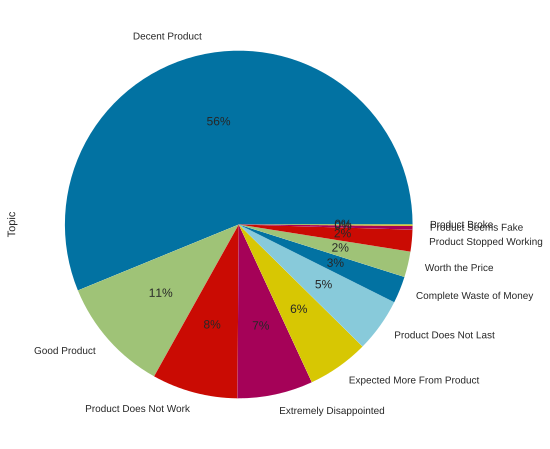

In [17]:
fig = plt.figure(figsize=(8,8), dpi=300)
product['Topic'].value_counts().plot(kind='pie', autopct='%1.0f%%');



---



---



## 2. Data Exploration: Low Rating Latent Feature Categorization and TSNE. 




In [18]:
topic_dict = {}
for i in df_topic['Topic']:
  if i in topic_dict:
    topic_dict[i] +=1
  else:
    topic_dict[i] =1
topic_dict

{'Complete Waste of Money': 6736,
 'Decent Product': 60418,
 'Expected More From Product': 7968,
 'Extremely Disappointed': 13613,
 'Good Product': 11955,
 'Product Broke': 2371,
 'Product Does Not Last': 4810,
 'Product Does Not Work': 19635,
 'Product Seems Fake': 3415,
 'Product Stopped Working': 2783,
 'Worth the Price': 7387}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

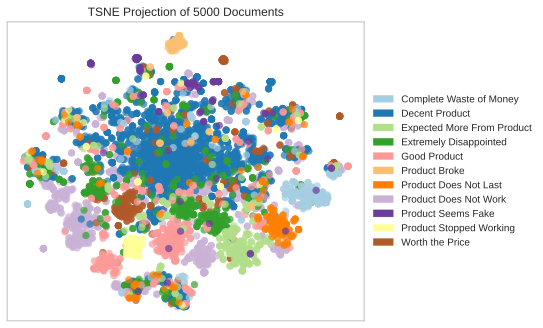

In [19]:

my_stop_words = text.ENGLISH_STOP_WORDS.union(["really", "just", "don", "like", "total", "does", "did", "months", "amazon", "left", "ve",
                                                "hair", "nails", "flat iron", "flat", "curling iron", "curling", "iron", "half", "curl",
                                                "rollers", "products", "spray", "rollers", "lotion", "love", "dry shampoo", "conditioner",
                                                "pump", "shampoos", "shampoo", "dry shampoo", "bottle", "hot", "scent", "perfume", "smells",
                                                "smell", "oily", "dry", "face", "cap", "came", "cream", "moisturizer", "sunscreen", "real",
                                                "reviews", "curly", "time", "bought", "buy", "looks", "nail polish", "pink", "light", "nail",
                                                "dark", "polish", "color", "arrived", "way", "day", "used", "using", "brush", "dryer", "long",
                                                "feel", "think", "got", "cleanser", "sure", "nice", "skin", "tone", "salon", "darker", "makes",
                                                "make", "look", "hard", "thought", "try", "bit", "use", "lid", "little", "tried", "product received",
                                                "received", "product", "shave", "mascara", "shaving", "hand", "smooth", "days", "weeks", "eye",
                                                "eyes", "makeup", "oil", "ordered", "purchase", "new", "purchased", "years"
                                                ])
  
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=my_stop_words, 
                              lowercase=True, ngram_range=(1,2), strip_accents = "ascii",
                              tokenizer=None)
X = tfidf_vect.fit_transform(df_below_three['reviewText'][0:5000]) 
y = df_below_three['Topic'][0:5000]

tsne = TSNEVisualizer(colormap = 'Paired', alpha=.7)
tsne.fit(X, y);
tsne.poof()

## 2. Data Exploration: High Rating Latent Feature Categorization and TSNE. 

In [20]:
df_high_topic = top_latent(df_above_four, 15, lda=False)

Top 10 words for topic #0:
['stuff great', 'great good', 'feels', 'great stuff', 'great works', 'great price', 'feels great', 'great great', 'works great', 'great']


Top 10 words for topic #1:
['owned', 'best far', 'best best', 'best price', 'best stuff', 'best market', 'far best', 'far', 'market', 'best']


Top 10 words for topic #2:
['feels', 'quality', 'great good', 'good quality', 'feels good', 'good stuff', 'works good', 'good good', 'good price', 'good']


Top 10 words for topic #3:
['wonders', 'fine', 'works wonders', 'good works', 'works better', 'works good', 'stuff works', 'great works', 'works great', 'works']


Top 10 words for topic #4:
['fine', 'worth', 'apply', 'work', 'need', 'goes', 'better', 'easy', 'doesn', 'perfect']


Top 10 words for topic #5:
['great amazing', 'absolutely amazing', 'absolutely', 'feels', 'amazing great', 'amazing works', 'feels amazing', 'works amazing', 'stuff amazing', 'amazing']


Top 10 words for topic #6:
['favorite lip', 'lip', 'cologne', 

In [21]:
map_dict = {0: 'Product Feels Great', 1: 'Best Product', 2: 'Excellent Quality', 3: 'Product Works Great', 4: 'Amazing Product', 
            5: 'Amazing Product', 6: 'Favorite Product', 7: 'Excellent Product', 8: 'Product Is Worth It', 
            9: 'Amazing Product', 10: 'Product Feels Great', 11: 'Family Loves Product', 12: 'Product Highly Recommended', 13: 'Feels Wonderful', 14: 'Great Customer Service'}

df_high_topic['Topic'] = df_high_topic['Topic'].map(map_dict)
df_high_topic

,overall,vote,verified,asin,reviewText,summary,overall_category,Topic
0,5,14,True,B00004U9V2,Believe me over the years I have tried many ma...,Best hand cream ever.,High Rating,Amazing Product
1,5,14,True,B00004U9V2,Believe me over the years I have tried many ma...,Best hand cream ever.,High Rating,Amazing Product
2,5,14,True,B00004U9V2,Believe me over the years I have tried many ma...,Best hand cream ever.,High Rating,Amazing Product
3,5,14,True,B00004U9V2,Believe me over the years I have tried many ma...,Best hand cream ever.,High Rating,Amazing Product
4,5,0,True,B00004U9V2,Ive used this lotion for many years. I try oth...,Ive used this lotion for many years. I try ...,High Rating,Amazing Product
...,...,...,...,...,...,...,...,...
417829,5,0,True,B01HIQEOLO,Product received as expected. Prompt shipment.,Five Stars,High Rating,Amazing Product
417830,5,0,True,B01HIQEOLO,Love CND shellac. Nice color,Great product,High Rating,Amazing Product
417831,5,0,True,B01HIQEOLO,Great color and I prefer shellac over gel,Five Stars,High Rating,Product Feels Great
417832,5,0,True,B01HIQEOLO,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,High Rating,Best Product


### 2b. Data Exploration: Specific Product Analysis (High Rated) B002K6AHQY - Nail Polish

In [22]:
high_product = df_high_topic[df_high_topic['asin']=='B002K6AHQY'].reset_index(drop=True)
high_product

,overall,vote,verified,asin,reviewText,summary,overall_category,Topic
0,4,0,True,B002K6AHQY,This is CND's new product. The product itself...,Lovely!,High Rating,Great Customer Service
1,4,0,True,B002K6AHQY,This is CND's new product. The product itself...,Nice color,High Rating,Great Customer Service
2,5,0,True,B002K6AHQY,Love the color. Product stays on forever.,Great color.,High Rating,Amazing Product
3,5,0,True,B002K6AHQY,Perfect color for French nails (studio white)....,French tip Studio White,High Rating,Amazing Product
4,5,0,True,B002K6AHQY,I love this nail polish. I get a manicure wee...,Beautiful colors and stays on well.,High Rating,Amazing Product
...,...,...,...,...,...,...,...,...
1991,5,0,True,B002K6AHQY,Love the color easy to use quickly delivered.,Item as described.,High Rating,Amazing Product
1992,5,0,True,B002K6AHQY,Long-lasting polish made it through hiking san...,still looks fantastic!,High Rating,Amazing Product
1993,4,0,True,B002K6AHQY,I love this color on my toes in the summer. T...,Fun summer color,High Rating,Amazing Product
1994,4,0,True,B002K6AHQY,Like .Nail is good,Like. Nail is good,High Rating,Excellent Quality


In [23]:
high_product[4:5]['reviewText'].values

array(["I love this nail polish.  I get a manicure weekly and most nail polishes damage my nails (Opi L'Oreal Revlon).  CND doesn't effect my nails and more importantly they have beautiful colors.  I'm getting more.  I bought 2 previous to this but they weren't delivered so I sent this one to my office and voila!"],
      dtype=object)

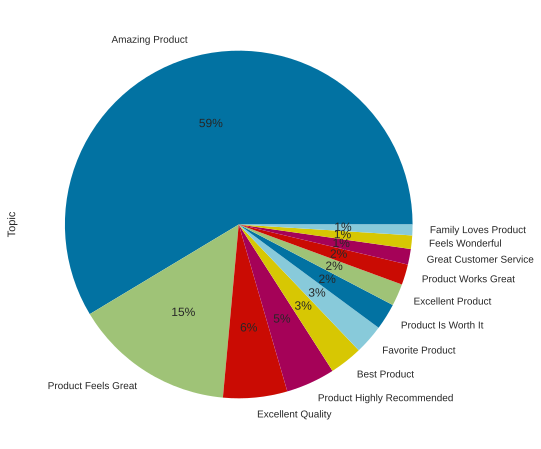

In [24]:
fig = plt.figure(figsize=(8,8), dpi=300)
high_product['Topic'].value_counts().plot(kind='pie', autopct='%1.0f%%');



---



---



## 2. Data Exploration: High Rated Analysis TSNE

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

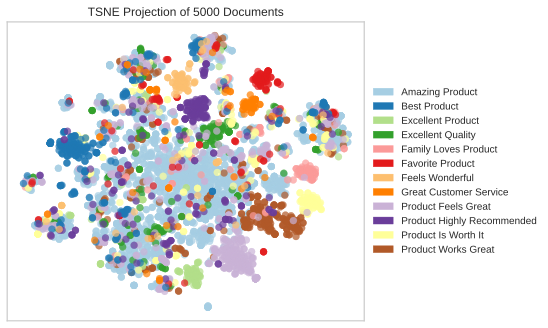

In [25]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["really", "just", "don", "like", "total", "does", "did", "months", "amazon", "left", "ve",
                                                "hair", "nails", "flat iron", "flat", "curling iron", "curling", "iron", "half", "curl",
                                                "rollers", "products", "spray", "rollers", "lotion", "love", "dry shampoo", "conditioner",
                                                "pump", "shampoos", "shampoo", "dry shampoo", "bottle", "hot", "scent", "perfume", "smells",
                                                "smell", "oily", "dry", "face", "cap", "came", "cream", "moisturizer", "sunscreen", "real",
                                                "reviews", "curly", "time", "bought", "buy", "looks", "nail polish", "pink", "light", "nail",
                                                "dark", "polish", "color", "arrived", "way", "day", "used", "using", "brush", "dryer", "long",
                                                "feel", "think", "got", "cleanser", "sure", "nice", "skin", "tone", "salon", "darker", "makes",
                                                "make", "look", "hard", "thought", "try", "bit", "use", "lid", "little", "tried", "product received",
                                                "received", "product", "shave", "mascara", "shaving", "hand", "smooth", "days", "weeks", "eye",
                                                "eyes", "makeup", "oil", "ordered", "purchase", "new", "purchased", "years"
                                                ])
  
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=my_stop_words, 
                              lowercase=True, ngram_range=(1,2), strip_accents = "ascii",
                              tokenizer=None)
X = tfidf_vect.fit_transform(df_above_four['reviewText'][0:5000]) 
y = df_above_four['Topic'][0:5000]

tsne = TSNEVisualizer(colormap = 'Paired', alpha=.7)
tsne.fit(X, y);
tsne.poof()

# 3. Model Building to Predict High/Low Rating

## 3. Model Building: Data Splitting 

Low Rating: 141091
High Rating: 417834
Proportion: 0.34 : 1


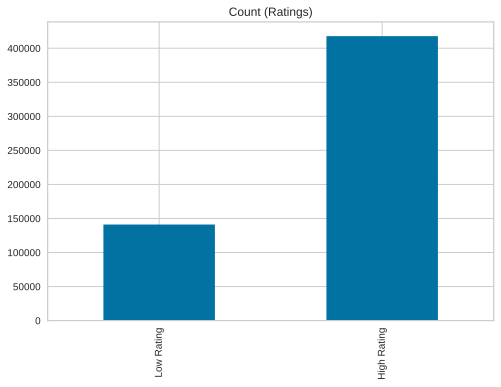

In [26]:

target_count = df_new.overall_category.value_counts().reindex(index = ['Low Rating', 'High Rating'])
print('Low Rating:', target_count[0])
print('High Rating:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (Ratings)');

## 3. Model Building: Randomly sample High/Low Ratings of equal weights.

Random Sub-sample:
Low Rating     35272
High Rating    35271
Name: overall_category, dtype: int64


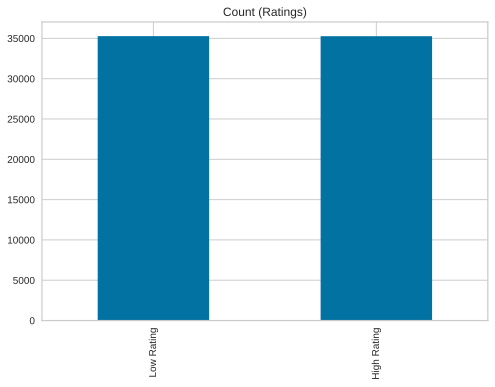

In [27]:
count_class_0, count_class_1 = target_count[0], target_count[1]

n =int(.25 * count_class_0)

df_class_0 = df_new[df_new['overall_category']=='Low Rating']
df_class_1 = df_new[df_new['overall_category']=='High Rating']

df_class_0_sub = df_class_0.sample(n, replace=False)
df_class_1_sub = df_class_1.sample(n-1, replace=False)
df_balanced = pd.concat([df_class_0_sub, df_class_1_sub], axis=0)

# Get remaining indexes to be used for final testing.
df_class_0_remain = df_class_0.loc[~df_class_0.index.isin(df_class_0_sub.index)]
df_class_1_remain = df_class_1.loc[~df_class_1.index.isin(df_class_1_sub.index)]
df_remain = pd.concat([df_class_0_remain, df_class_1_remain], axis=0)


print('Random Sub-sample:')
print(df_balanced.overall_category.value_counts())

df_balanced.overall_category.value_counts().plot(kind='bar', title='Count (Ratings)');


## 3. Model Building: Keep untouched data for final model test.

Remaining Sample:
High Rating    382563
Low Rating     105819
Name: overall_category, dtype: int64


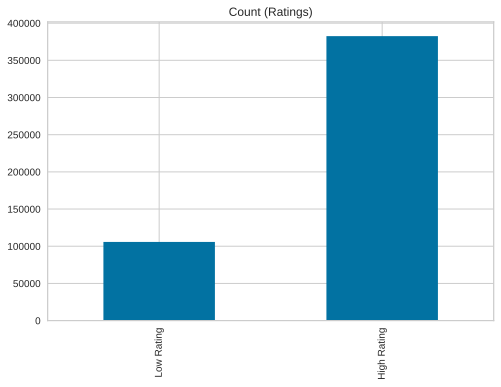

In [28]:
print('Remaining Sample:')
print(df_remain.overall_category.value_counts())
df_remain.overall_category.value_counts().reindex(index = ['Low Rating', 'High Rating']).plot(kind='bar', title='Count (Ratings)');


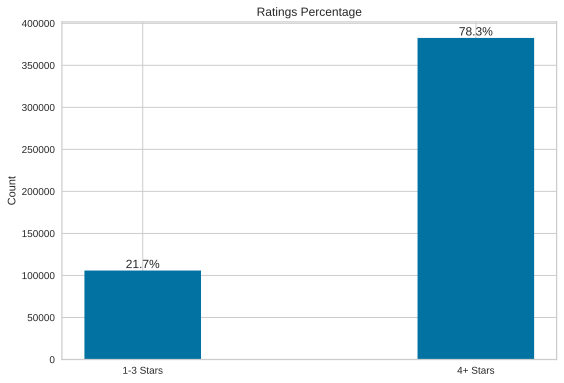

In [29]:
df_below_three, df_above_four = product_rating(df_remain)

## 3. Model Building: Test 4-5 Models train/test on 50-50 sample of Low/High. Final test on 20-80 Low/High sample of untouched data.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


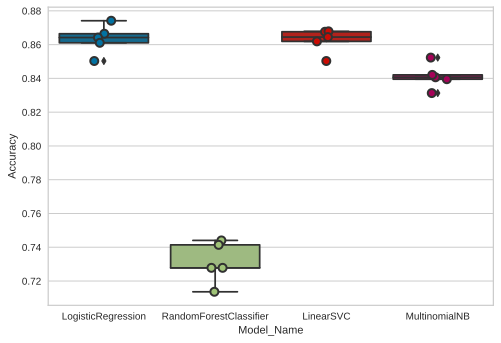

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score


def model_check(df):
  X_train, X_test, y_train, y_test = train_test_split(df_balanced['reviewText'], df_balanced['overall_category'], random_state = 0)
  count_vect = CountVectorizer()
  tfidf_transformer = TfidfTransformer()
  

  X_test_counts = count_vect.fit_transform(X_test)
  X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

  models = [LogisticRegression(),
      RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
      LinearSVC(max_iter=2500),
      MultinomialNB()
      


  ]
  CV = 5
  cv_df = pd.DataFrame(index=range(CV * len(models)))
  entries = []
  for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, X_test_tfidf, y_test, scoring='accuracy', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
  cv_df = pd.DataFrame(entries, columns=['Model_Name', 'fold_idx', 'Accuracy'])

  import seaborn as sns
  sns.boxplot(x='Model_Name', y='Accuracy', data=cv_df)
  sns.stripplot(x='Model_Name', y='Accuracy', data=cv_df, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
  plt.show()

model_check(df_balanced)


## 3. Model Building: LinearSVC model on train data then final untouched data. 

In [31]:
def fit_best_model(df_balanced, df):
  model = LinearSVC()

  my_stop_words = text.ENGLISH_STOP_WORDS.union()
  
  X_train, X_test, y_train, y_test= train_test_split(df_balanced['reviewText'], df_balanced['overall_category'], test_size=0.25, random_state=0)


  

  count_vect = CountVectorizer()
  
  X_train_counts = count_vect.fit_transform(X_train)
  tfidf_transformer = TfidfTransformer()
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

  clf = model.fit(X_train_tfidf, y_train)

  y_pred = clf.predict(count_vect.transform(X_test))
  y_full_pred = clf.predict(count_vect.transform(df_remain['reviewText']))

  print(report(y_test, y_pred, target_names=['High Rating', 'Low Rating']))
  print(report(df['overall_category'], y_full_pred, target_names=['High Rating', 'Low Rating']))
fit_best_model(df_balanced, df_remain)

              precision    recall  f1-score   support

 High Rating       0.86      0.87      0.87      8944
  Low Rating       0.87      0.85      0.86      8692

    accuracy                           0.86     17636
   macro avg       0.86      0.86      0.86     17636
weighted avg       0.86      0.86      0.86     17636

              precision    recall  f1-score   support

 High Rating       0.95      0.87      0.91    382563
  Low Rating       0.65      0.84      0.73    105819

    accuracy                           0.87    488382
   macro avg       0.80      0.86      0.82    488382
weighted avg       0.89      0.87      0.87    488382



## 3. Model Building: Logistic Regression Classifier model on train and final test data. 

In [32]:

def fit_best_model(df_balanced, df):
  model = LogisticRegression()

  my_stop_words = text.ENGLISH_STOP_WORDS.union(["really", "just", "don", "like", "total", "does", "did", "months", "amazon", "left", "ve",
                                                  "hair", "nails", "flat iron", "flat", "curling iron", "curling", "iron", "half", "curl",
                                                  "rollers", "products", "spray", "rollers", "lotion", "love", "dry shampoo", "conditioner",
                                                  "pump", "shampoos", "shampoo", "dry shampoo", "bottle", "hot", "scent", "perfume", "smells",
                                                  "smell", "oily", "dry", "face", "cap", "came", "cream", "moisturizer", "sunscreen", "real",
                                                  "reviews", "curly", "time", "bought", "buy", "looks", "nail polish", "pink", "light", "nail",
                                                  "dark", "polish", "color", "arrived", "way", "day", "used", "using", "brush", "dryer", "long",
                                                  "feel", "think", "got", "cleanser", "sure", "nice", "skin", "tone", "salon", "darker", "makes",
                                                  "make", "look", "hard", "thought", "try", "bit", "use", "lid", "little", "tried", "product received",
                                                  "received", "product", "shave", "mascara", "shaving", "hand", "smooth"
                                                    ])
  
  X_train, X_test, y_train, y_test= train_test_split(df_balanced['reviewText'], df_balanced['overall_category'], test_size=0.25, random_state=0)

  count_vect = CountVectorizer()
  
  X_train_counts = count_vect.fit_transform(X_train)
  tfidf_transformer = TfidfTransformer()
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

  clf = model.fit(X_train_tfidf, y_train)

  y_pred = clf.predict(count_vect.transform(X_test))
  y_full_pred = clf.predict(count_vect.transform(df_remain['reviewText']))

  print(report(y_test, y_pred, target_names=['High Rating', 'Low Rating']))
  print(report(df['overall_category'], y_full_pred, target_names=['High Rating', 'Low Rating']))
fit_best_model(df_balanced, df_remain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

 High Rating       0.84      0.87      0.85      8944
  Low Rating       0.86      0.83      0.84      8692

    accuracy                           0.85     17636
   macro avg       0.85      0.85      0.85     17636
weighted avg       0.85      0.85      0.85     17636

              precision    recall  f1-score   support

 High Rating       0.95      0.87      0.90    382563
  Low Rating       0.63      0.82      0.71    105819

    accuracy                           0.86    488382
   macro avg       0.79      0.84      0.81    488382
weighted avg       0.88      0.86      0.86    488382



# Below are scripts only used for testing and not in final model.



In [33]:

def word_cloud(corpus_dict):
  wc = WordCloud(background_color="white",
                width=1000, height=1000,
                max_words=100, relative_scaling=0.5,
                normalize_plurals=False).generate_from_frequencies(get_dictionary(corpus_dict))

  fig, ax = plt.subplots(figsize=(10, 10))

  ax.axis('off')

  ax.imshow(wc);

In [34]:
def dict_style(df):
  x = [d for d in df['style']]
  keylist = {}
  for i in x:
    if i ==0:
      pass
    else:
      for key, value in i.items():
        if key in keylist:
          keylist[key] +=1
        else:
          keylist[key] =1
  return keylist
dict_style(df)

KeyError: ignored

In [ ]:
def mask_df(df, string):
  key = string
  size_mask = []
  for i in range(len(df)):
    if df['style'][i] == 0:
      size_mask.append(False)
    else:
      size_mask.append(key in df['style'][i])
  return df[size_mask].reset_index(drop=True)
mask_df(df, 'Size:')


In [ ]:
from sklearn.cluster import KMeans

my_stop_words = text.ENGLISH_STOP_WORDS.union(["really", "just", "don", "like", "total", "does", "did", "months", "amazon", "left", "ve",
                                                "hair", "nails", "flat iron", "flat", "curling iron", "curling", "iron", "half", "curl",
                                                "rollers", "products", "spray", "rollers", "lotion", "love", "dry shampoo", "conditioner",
                                                "pump", "shampoos", "shampoo", "dry shampoo", "bottle", "hot", "scent", "perfume", "smells",
                                                "smell", "oily", "dry", "face", "cap", "came", "cream", "moisturizer", "sunscreen", "real",
                                                "reviews", "curly", "time", "bought", "buy", "looks", "nail polish", "pink", "light", "nail",
                                                "dark", "polish", "color", "arrived", "way", "day", "used", "using", "brush", "dryer", "long",
                                                "feel", "think", "got", "cleanser", "sure", "nice", "skin", "tone", "salon", "darker", "makes",
                                                "make", "look", "hard", "thought", "try", "bit", "use", "lid", "little", "tried", "product received",
                                                "received", "product", "shave", "mascara", "shaving", "hand", "smooth", "eye", "eyes", "makeup",
                                               "eyeliner", "circles"
                                                ])

vectorizer = TfidfVectorizer(stop_words=my_stop_words)
X = vectorizer.fit_transform(df_below_three['reviewText'])

true_k = 12
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    ind_list = []
    for ind in order_centroids[i, :10]:
      ind_list.append(terms[ind])
    print(ind_list)
        
